In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer

from keras.models import Sequential
from keras.layers import Dense

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

#import statsmodels.api as sm,

import seaborn as sns; sns.set()

from pandas.core import datetools
%matplotlib inline


Using TensorFlow backend.


# Data Acquisition
The following code imports and validates the LendingClub data.

In [2]:
converters = dict(
    id=str,
    desc=str,
    hardship_type=str,
    hardship_reason=str,
    hardship_status=str,
    hardship_loan_status=str,
    verification_status_joint=str
)
dates = [
    'next_pymnt_d',
    'hardship_start_date',
    'hardship_end_date',
    'payment_plan_start_date',
    'earliest_cr_line',
    'issue_d'
]

In [3]:
import pickle
df = pickle.load(open("sub_data.p",'rb'))

In [3]:
# Imports loan data

df = pd.DataFrame()
basepath='./Source Data/Loan Data/'
files = os.listdir(basepath)
csvs = []

for file in files:
    if re.match('.*csv$',file):
        csvs += [file]

if 0:
    #ignore this - was trying to pickle the data into
    #formats like feather, hdf5, native python pickling, etc
    # but found issues on python 3.7
    df=pd.read_pickle(basepath+'df.pkl')
else:
    cols = df.dtypes
    for csv in csvs:
        path = basepath + csv
        print("Reading",path)
        tdf = pd.read_csv(path,header=1,low_memory=False)
        df=df.append(tdf)
    
df.reset_index(inplace=True) # This will help with joining back data if necessary.

print(df.shape)

Reading ./Source Data/Loan Data/LoanStats3a_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3b_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3c_securev1.csv
Reading ./Source Data/Loan Data/LoanStats3d_securev1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2016Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q1.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q2.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q3.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2017Q4.csv
Reading ./Source Data/Loan Data/LoanStats_securev1_2018Q1.csv
(1873317, 152)


In [4]:
pd.set_option('display.max_rows', 200)
print(df.dtypes)
pd.set_option('display.max_rows', 200)

index                                                  int64
id                                                    object
member_id                                            float64
loan_amnt                                            float64
funded_amnt                                          float64
funded_amnt_inv                                      float64
term                                                  object
int_rate                                              object
installment                                          float64
grade                                                 object
sub_grade                                             object
emp_title                                             object
emp_length                                            object
home_ownership                                        object
annual_inc                                           float64
verification_status                                   object
issue_d                 

In [5]:
# Checks for duplicates within our combined data
#df['count']=1 # Generate field to measure the number of occurances

#counts = df.groupby('id')['count'].count()
#print('Data are duplicated %i times.' % len(counts[counts>1]))

Data are duplicated 0 times.

Some data are not useful as a predictor. Because we are going to use these data as a training set, we need to remove data that are not useful for predictions. There are two categories of data that are not useful for predictions. First, we need information about loans that have fully run their course. That is to say, we need to see loans that have either been paid in full or written off. It is not useful to see loans that are currently delinquent or current on payments but still early in the loan. Second, we need to remove predictors that are not import for predicting the loan. For example the URL has no impact on the borrower's ability to repay the loan. If we need this data in the future, we can still pair it back with the original dataframe.

In [6]:
has_data = {}
for column in df.columns:
    has_data[column] = len(df[column].dropna())
#print(len(has_data))
#has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=50
for i,j in zip(order_has_data[0:top_sparse],range(top_sparse)):
    print(j, i, has_data[i])

0 member_id 0
1 orig_projected_additional_accrued_interest 584
2 hardship_type 742
3 hardship_reason 742
4 hardship_status 742
5 deferral_term 742
6 hardship_amount 742
7 hardship_start_date 742
8 hardship_end_date 742
9 payment_plan_start_date 742
10 hardship_length 742
11 hardship_dpd 742
12 hardship_loan_status 742
13 hardship_payoff_balance_amount 742
14 hardship_last_payment_amount 742
15 sec_app_mths_since_last_major_derog 1884
16 debt_settlement_flag_date 2268
17 settlement_status 2268
18 settlement_date 2268
19 settlement_amount 2268
20 settlement_percentage 2268
21 settlement_term 2268
22 sec_app_revol_util 5469
23 revol_bal_joint 5555
24 sec_app_fico_range_low 5555
25 sec_app_fico_range_high 5555
26 sec_app_earliest_cr_line 5555
27 sec_app_inq_last_6mths 5555
28 sec_app_mort_acc 5555
29 sec_app_open_acc 5555
30 sec_app_open_act_il 5555
31 sec_app_num_rev_accts 5555
32 sec_app_chargeoff_within_12_mths 5555
33 sec_app_collections_12_mths_ex_med 5555
34 verification_status_joint

Based on the data, it appears that joint applications are a fairly new development in these data. We see only about 50,000 instances where the data are included for joint applications. The following visualization shows the relationship for income in joint applicants.

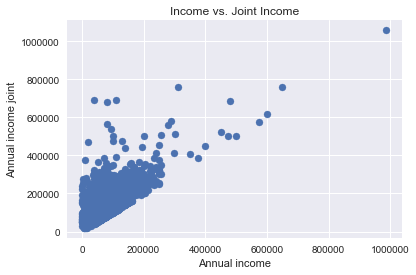

In [7]:
joint_fil = (df['annual_inc']>0)&(df['annual_inc_joint']>0)
plt.scatter(df[joint_fil]['annual_inc'],df[joint_fil]['annual_inc_joint'])
plt.title('Income vs. Joint Income')
plt.xlabel('Annual income')
plt.ylabel('Annual income joint')
plt.show;


Because of the high risk of multicolinearity, and the small number of observations, we are dropping this from the dataset. We will still keep a dummy variable that treats joint applications differently, but we will not consider the joint income of applicants.

In [8]:
# Convert dates to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'])

#determine age of credit line prior to loan issue and convert to integer
# days of credit history
df['earliest_cr_line'] = (df['issue_d']-df['earliest_cr_line']).dt.days

# convert issue_d to a year to consider economic conditions
#SHOULD WE GO TO QUARTERS?
df['issue_d'] = df['issue_d'].dt.year

print(df.shape)

(187331, 153)


In [9]:
# Limit to loans that are paid in full or written off. Uses dates so that 
# loans that are delinquent are not disproportionaltely dropped from data

mature_filter = (df['loan_status']=='Fully Paid')|(df['loan_status']=='Charged Off')
#mature_filter = (df['loan_status']=='Fully Paid')
#latest_mature = df[~mature_filter]['issue_d'].min()
#latest_mature
#reduced_df = df[df['issue_d']<=latest_mature]
reduced_df = df[mature_filter] # Pulls only loans that are charged off or paid in full.
#
## Use my documentation to filter to only 
data_dict = pd.read_excel('./Source Data/LCDataDictionary.xlsx',sheet_name='LoanStats')
features = list(data_dict[data_dict['Useful Predictor']=='Yes']['LoanStatNew'].values)
kaggle_features=["addr_state", "annual_inc", "delinq_2yrs", "desc", "dti", "earliest_cr_line", "emp_length",
                 "emp_title", "grade", "home_ownership", "id", "inq_fi", "inq_last_6mths", "installment",
                 "int_rate", "loan_amnt", "loan_status", "mths_since_last_delinq", "mths_since_last_major_derog",
                 "mths_since_last_record", "open_acc", "pub_rec", "purpose", "pymnt_plan", "revol_bal",
                 "revol_util", "sub_grade", "term", "title", "total_acc", "url", "verification_status", "zip_code"]
#reduced_df=reduced_df[features]
non_kaggle_features=['application_type','fico_range_low','fico_range_high',"total_pymnt"]
reduced_df=reduced_df[kaggle_features+non_kaggle_features]

# Combines fields when necessary
reduced_df['fico_est'] = (reduced_df['fico_range_low']+reduced_df['fico_range_high'])/2

reduced_df.drop(columns=['fico_range_low','fico_range_high'],inplace=True)

print(reduced_df.shape)

(102069, 36)


In [10]:
# backup our df
backup_df = reduced_df.copy()

In [11]:
#restore our df
reduced_df = backup_df.copy()

In [12]:
# Convert strings to numbers emp_length, int_rate, revol_util
emp_length_map={'10+ years':10, '< 1 year':0, '1 year':1, '3 years':3, '8 years':8, '9 years':9,
                '4 years':4, '5 years':5, '6 years':6, '2 years':2, '7 years':7}

reduced_df['emp_length']=reduced_df['emp_length'].replace(pd.Series(emp_length_map))

grade_map={"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7}
reduced_df['grade']=reduced_df['grade'].replace(pd.Series(grade_map))

reduced_df['int_rate']=reduced_df['int_rate'].apply(lambda x: float(x[:-1]))
reduced_df['revol_util']=reduced_df['revol_util'].apply(lambda x:
                                                        x[:-1] if isinstance(x, str) else np.nan).astype(float)

reduced_df['earliest_cr_line']=reduced_df['earliest_cr_line'].apply(lambda x:
                                                        0.0 if np.isnan(x) else x)

reduced_df.drop(columns=['title','emp_title','desc','url','id','sub_grade','addr_state','zip_code'],inplace=True)

print(reduced_df.shape)

(102069, 28)


# Which values are categorical?

In [13]:
n_options = {}
for column in reduced_df.columns:
    n_options[column] = len(reduced_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:50]:
    print(i, n_options[i],reduced_df[i].unique())

pymnt_plan 1 ['n']
loan_status 2 ['Fully Paid' 'Charged Off']
term 2 [' 36 months' ' 60 months']
application_type 2 ['Individual' 'Joint App']
verification_status 3 ['Verified' 'Source Verified' 'Not Verified']
home_ownership 6 ['MORTGAGE' 'OWN' 'RENT' 'ANY' 'NONE' 'OTHER']
grade 7 [1 2 5 4 3 7 6]
inq_last_6mths 9 [2. 1. 0. 3. 5. 4. 6. 8. 7.]
emp_length 12 [ 0. nan 10.  2.  7.  8.  3.  1.  6.  9.  5.  4.]
purpose 14 ['credit_card' 'debt_consolidation' 'home_improvement' 'small_business'
 'other' 'car' 'moving' 'major_purchase' 'medical' 'vacation' 'house'
 'educational' 'wedding' 'renewable_energy']
pub_rec 18 [ 0.  1.  2.  3.  5.  6.  7.  4.  8. 13. 12.  9. 20. 19. 15. 11. 46. 10.]
delinq_2yrs 20 [ 0.  1.  4.  2. 10.  3.  5. 15.  8.  7.  6.  9. 11. 12. 13. 19. 14. 16.
 20. 18.]
inq_fi 20 [nan  2.  1.  0.  3.  6.  5.  4.  8.  7. 14.  9. 13. 15. 10. 11. 12. 17.
 19. 28.]
fico_est 38 [717.  662.  692.  697.  687.  682.  702.  667.  762.  737.  727.  802.
 672.  752.  722.  712.  772.  70

total_pymnt 101210 [16693.44316128  4325.34        7662.18       ...  8855.69999417
 15408.15226162 21528.11917407]


Based on these results, we will have to encode several data as dummy variables:

- application_type
- term
- verification_status
- home_ownership
- purpose


In [14]:
seta=set(reduced_df.columns)

reduced_df=pd.get_dummies(data=reduced_df,columns=['pymnt_plan','loan_status','application_type','term',
                                                   'verification_status',
                                                   'home_ownership','purpose'],
                          drop_first=True)


setb=set(reduced_df.columns)
print(setb-seta)
print(reduced_df.shape)

{'term_ 60 months', 'home_ownership_OWN', 'purpose_major_purchase', 'purpose_home_improvement', 'home_ownership_MORTGAGE', 'purpose_debt_consolidation', 'purpose_wedding', 'home_ownership_NONE', 'purpose_other', 'home_ownership_RENT', 'purpose_educational', 'verification_status_Verified', 'purpose_house', 'verification_status_Source Verified', 'purpose_moving', 'purpose_credit_card', 'loan_status_Fully Paid', 'purpose_medical', 'purpose_renewable_energy', 'home_ownership_OTHER', 'application_type_Joint App', 'purpose_small_business', 'purpose_vacation'}
(102069, 44)


# How to treat NaN?

For now, let's remove majority NaN columns...

In [15]:
has_data = {}
for column in reduced_df.columns:
    has_data[column] = len(reduced_df[column].dropna())
has_data

order_has_data=sorted(has_data, key=lambda dict_key: has_data[dict_key])

top_sparse=25
for i,j in zip(range(top_sparse),order_has_data[0:top_sparse]):
    print(i,j, has_data[j])

0 mths_since_last_record 17208
1 mths_since_last_major_derog 26492
2 inq_fi 29454
3 mths_since_last_delinq 50173
4 emp_length 96546
5 revol_util 102003
6 dti 102061
7 annual_inc 102069
8 delinq_2yrs 102069
9 earliest_cr_line 102069
10 grade 102069
11 inq_last_6mths 102069
12 installment 102069
13 int_rate 102069
14 loan_amnt 102069
15 open_acc 102069
16 pub_rec 102069
17 revol_bal 102069
18 total_acc 102069
19 total_pymnt 102069
20 fico_est 102069
21 loan_status_Fully Paid 102069
22 application_type_Joint App 102069
23 term_ 60 months 102069
24 verification_status_Source Verified 102069


In [16]:
nonnan_df=reduced_df.fillna(0)
#nonnan_df=reduced_df.drop(columns=order_has_data[0:4])
print(nonnan_df.shape)
print(len(reduced_df.dropna()),len(nonnan_df.dropna()))

(102069, 44)
1498 102069


In [17]:
nonnan_df=nonnan_df.dropna()
print(nonnan_df.shape)

n_options = {}
for column in nonnan_df.columns:
    n_options[column] = len(nonnan_df[column].unique())
#n_options
order_n_options=sorted(n_options, key=lambda dict_key: n_options[dict_key])

for i in order_n_options[0:49]:
    print(i, n_options[i],nonnan_df[i].unique())

(102069, 44)
loan_status_Fully Paid 2 [1 0]
application_type_Joint App 2 [0 1]
term_ 60 months 2 [0 1]
verification_status_Source Verified 2 [0 1]
verification_status_Verified 2 [1 0]
home_ownership_MORTGAGE 2 [1 0]
home_ownership_NONE 2 [0 1]
home_ownership_OTHER 2 [0 1]
home_ownership_OWN 2 [0 1]
home_ownership_RENT 2 [0 1]
purpose_credit_card 2 [1 0]
purpose_debt_consolidation 2 [0 1]
purpose_educational 2 [0 1]
purpose_home_improvement 2 [0 1]
purpose_house 2 [0 1]
purpose_major_purchase 2 [0 1]
purpose_medical 2 [0 1]
purpose_moving 2 [0 1]
purpose_other 2 [0 1]
purpose_renewable_energy 2 [0 1]
purpose_small_business 2 [0 1]
purpose_vacation 2 [0 1]
purpose_wedding 2 [0 1]
grade 7 [1 2 5 4 3 7 6]
inq_last_6mths 9 [2. 1. 0. 3. 5. 4. 6. 8. 7.]
emp_length 11 [ 0. 10.  2.  7.  8.  3.  1.  6.  9.  5.  4.]
pub_rec 18 [ 0.  1.  2.  3.  5.  6.  7.  4.  8. 13. 12.  9. 20. 19. 15. 11. 46. 10.]
inq_fi 19 [ 0.  2.  1.  3.  6.  5.  4.  8.  7. 14.  9. 13. 15. 10. 11. 12. 17. 19.
 28.]
delinq_2y

# What factors are correlated?

In [18]:
#correlatable columns
corr_columns = order_n_options[23:]
print(nonnan_df[corr_columns].dtypes)

grade                            int64
inq_last_6mths                 float64
emp_length                     float64
pub_rec                        float64
inq_fi                         float64
delinq_2yrs                    float64
fico_est                       float64
open_acc                       float64
total_acc                      float64
mths_since_last_delinq         float64
mths_since_last_record         float64
mths_since_last_major_derog    float64
earliest_cr_line               float64
int_rate                       float64
revol_util                     float64
loan_amnt                      float64
dti                            float64
annual_inc                     float64
installment                    float64
revol_bal                      float64
total_pymnt                    float64
dtype: object


Factors with high correlation (> +/-0.7) are:
	 0 grade vs int_rate = 0.9537742810438863
	 1 int_rate vs grade = 0.9537742810438863
	 2 loan_amnt vs installment = 0.9534544047118316
	 3 loan_amnt vs total_pymnt = 0.8461576004787498
	 4 installment vs loan_amnt = 0.9534544047118317
	 5 installment vs total_pymnt = 0.8093655265644444
	 6 total_pymnt vs loan_amnt = 0.8461576004787498
	 7 total_pymnt vs installment = 0.8093655265644443


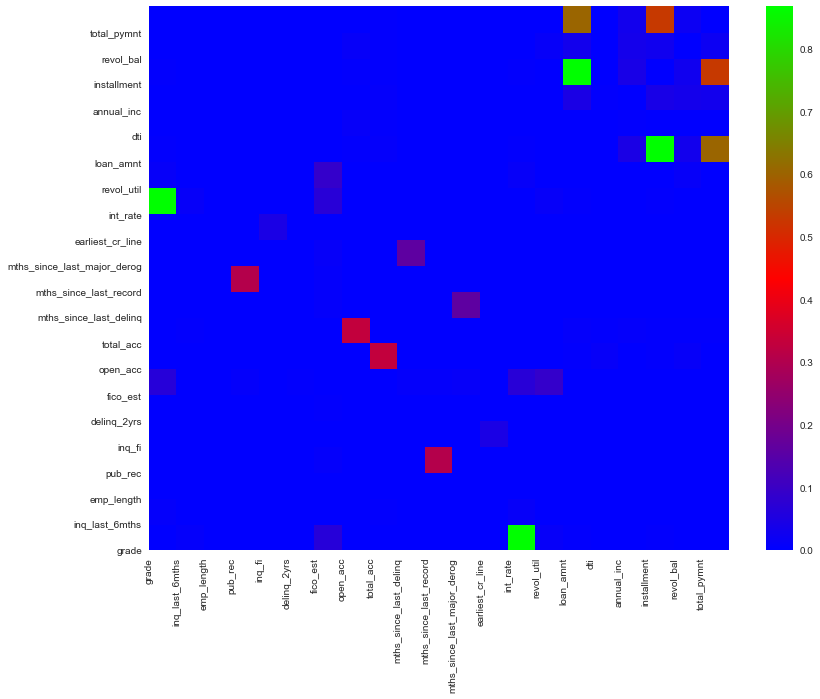

In [19]:
corr_df=nonnan_df[corr_columns]

matrix=np.corrcoef(corr_df,rowvar=False)-np.eye(len(corr_df.columns))


i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> +/-0.7) are:")
for k in range(len(i)):
    print("\t",k,corr_df.columns[i[k]],"vs",corr_df.columns[j[k]],"=",matrix[i[k]][j[k]])
    

# cube each value to highlight higher correlation elements
matrix=abs(matrix**3)
plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(corr_df.columns)), corr_df.columns,rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar(cmap='brg')
plt.show()

## Removing redundancy
We see that some of the factors in this dataset are two ways of measuring the same thing. For example, interest rates (`int_rate`) and the grading of the loan (`grade`) two ways of saying the same thing. A lower grade of loan indicates higher risk and higher risk is offset with a higher interest rate. Indeed, we see a large amount of correlation between the two fields.

As another example, we can see the percentage of bankcard accounts > 75% of the limit (`percent_bc_gt_75`) is highly correlated with the utilization of bank cards(`revol_bal`). Both of these are similar to the maximum amount of credit utilization (`total_rev_hi_lim`).

For this reason we need to select variables with high correlation and choose the variables that will have the biggest impact on our model. I have created the following groups that will need to be consolidated.

## High-Magnitude Factors
The following code regularizes the data and then looks for the regressor that, when considered independently has the higest impact on the model.

In [20]:
# Create standardized dataframe
std_df = nonnan_df.copy()
std_df.drop(columns=['out_prncp', 'out_prncp_inv'],inplace=True) # Drop because there is no variation in these columns
y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
for col in std_df.columns:
    std_df[col] = (std_df[col] - std_df[col].min()) / (std_df[col].max() - std_df[col].min())
x_full=std_df.drop(columns=['loan_amnt','loan_amnt'])
# Revolving debt maximum related variables
revolving = [
    'bc_open_to_buy',
    'num_rev_accts',
    'num_rev_tl_bal_gt_0',
    'revol_bal',
    'revol_util',
    'total_rev_hi_lim',
    'tot_hi_cred_lim',
    'num_il_tl',
    'open_acc',
    'num_bc_tl'
]

test_df = pd.DataFrame(columns=['Predictor','ABS Coef','R2'])
for col in revolving:
    cols_to_drop = revolving.copy()
    cols_to_drop.remove(col)
    x=x_full.drop(columns=cols_to_drop)
    test_reg = LinearRegression().fit(x,y)
    test_coef = test_reg.coef_[list(x.columns).index(col)]
    test_score = test_reg.score(x,y)
    test_df = test_df.append({
        'Predictor':col,
        'ABS Coef':abs(test_coef),
        'R2':test_score
    },ignore_index=True)
test_df

KeyError: "labels ['out_prncp' 'out_prncp_inv'] not contained in axis"

By far, total Revolving Debt limit has the biggest impact in terms of magnitude. We should keep this as the one regressor to represent revolving debt. This will help us to eliminate multicolinearity. Let's explore the impact this has on our correlation matrix

Note:
I did not perform the same analysis for the grade and interest rate. The loans are structured so that the grade determines the range of interest rates. The steps within the grade specifically determine the interest rate. Therefore, the grade the step and the rate all give the same information, but the rate gives the specific detail.

Note: In the new dataset, I replace the payment amount with the percentage of income that is dedicated to the payment. We can have all the factors to calculate loan amount (term, rate, and original balance) as individual regressors. Replacing it will still capture a critical element of the loan amount while removing multicolinearity.

In [ ]:
reduc_corr_columns = corr_columns.copy()

#reduc_corr_columns[]
to_remove = revolving.copy()
to_remove += ['grade'] # Extra code to drop grade

to_remove.remove('total_rev_hi_lim')
for x in to_remove:
    reduc_corr_columns.remove(x)

corr_df=nonnan_df[reduc_corr_columns]

matrix=np.corrcoef(corr_df,rowvar=False)-np.eye(len(corr_df.columns))


i,j=np.nonzero(abs(matrix) > 0.7)
print("Factors with high correlation (> +/-0.7) are:")
for k in range(len(i)):
    print("\t",k,corr_df.columns[i[k]],"vs",corr_df.columns[j[k]],"=",matrix[i[k]][j[k]])
    

# cube each value to highlight higher correlation elements
matrix=abs(matrix**3)
plt.figure(figsize=(13,10))
plt.pcolor(matrix,cmap='brg')

plt.xticks(range(len(corr_df.columns)), corr_df.columns,rotation='vertical')
plt.yticks(range(len(corr_df.columns)), corr_df.columns)
plt.colorbar(cmap='brg')
plt.show()

Notes:
- We still see some multicolinearity with the loan payment section. I plan to address additional factors in the factoring for income section.
- Total payments is one of the planned Y variables. For instances where it has high correlation, we expect to see strong relationships.


# Factoring for income
The correlation matrix emphasizes some factors in the data are highly correlated. In some instances, this correlation may be due to the fact that the predictors are dependent on other predictors. For example, we can consider three predictors in concert: the income, the loan repayment and the interest rate assigned by Lending Club. We are assuming that a higher amount of risk is related to a higher interest rate. That is to say, Lending Club assesses that loans are riskier based on loan to income ratio.

In [ ]:
# Shows the relationship between loan repayment and income:
features = ['annual_inc','installment','int_rate']

In [ ]:
# Large outliers make the trend difficult to understand so I'm making a trimmed df
temp_df = nonnan_df[nonnan_df['annual_inc']<150000][['installment','annual_inc']]
x = temp_df['annual_inc']
y = temp_df['installment']
plt.figure(figsize=(12,12))
plt.hexbin(x,y,gridsize =40)
plt.xlabel('Annual Income ($)')
plt.ylabel('Loan Installment Amount ($)')
plt.title('Income vs. Payment')
plt.show()

While it looks like income and loan amount are both approximately normally distributed, we see that there is a clear fan pattern here. No monthly loan payment is larger than approximately 1% of annual income. We may be able to keep valuable information from both datasets and reduce multicolinearity by considering not the individuals variables, but the relationships between them.

In [ ]:
nonnan_df['percent_of_income'] = nonnan_df['installment']*12/nonnan_df['annual_inc']
nonnan_df['percent_of_income'].describe()

Because we see some odd cases, I looked up an extreme and found that we see odd values when considering joint incomes. These instances are rare (fewer than 40 cases where total payments are greater than total income). This loan was funded as a joint application. As a result we are going to have to throw out any data about joint applications as it only represents 8000 cases, but creates significant leverage points.

In [21]:
# Testing an extreme example from the
df.iloc[1542746]

IndexError: single positional indexer is out-of-bounds

In [22]:
nonnan_df = nonnan_df[nonnan_df['application_type_Joint App']==0]

In [23]:
# Additional factors to remove
to_remove=[]
if 'installment' not in to_remove:
    #to_remove += ['installment']
    to_remove += ['total_pymnt','loan_amnt','grade','loan_status_Fully Paid']
features = list(set(nonnan_df.columns) - set(to_remove))

# Let's work with training and test sets

In [24]:
print(df.shape,nonnan_df.shape)

# need to look at interest rate as well!!!
#y=nonnan_df['total_pymnt']/(nonnan_df['installment']*36 + nonnan_df['installment']*nonnan_df['term_ 60 months']*24)
y=nonnan_df['loan_status_Fully Paid']
#y=nonnan_df['total_pymnt']/nonnan_df['loan_amnt']
print(features)
traintest_df=nonnan_df[features]
print(traintest_df.columns)

Xscaler = StandardScaler()
Xscaler.fit_transform(traintest_df)

X_traintune, X_test, y_traintune, y_test = train_test_split(
    traintest_df,y,test_size=0.2)#,random_state=42)#,stratify=nonnan_df[['loan_status']])

X_train, X_tune, y_train, y_tune = train_test_split(
    X_traintune,y_traintune,test_size=0.2)#,random_state=42)#,stratify=nonnan_df[['loan_status']])

print(X_train.shape,X_tune.shape,X_test.shape)

(187331, 153) (101129, 44)
['term_ 60 months', 'home_ownership_OWN', 'pub_rec', 'earliest_cr_line', 'purpose_major_purchase', 'emp_length', 'dti', 'purpose_home_improvement', 'inq_last_6mths', 'home_ownership_MORTGAGE', 'installment', 'purpose_debt_consolidation', 'mths_since_last_major_derog', 'purpose_wedding', 'home_ownership_NONE', 'purpose_other', 'home_ownership_RENT', 'purpose_educational', 'verification_status_Verified', 'purpose_house', 'open_acc', 'fico_est', 'verification_status_Source Verified', 'purpose_moving', 'inq_fi', 'purpose_credit_card', 'purpose_medical', 'int_rate', 'revol_util', 'total_acc', 'home_ownership_OTHER', 'application_type_Joint App', 'purpose_renewable_energy', 'purpose_small_business', 'mths_since_last_record', 'delinq_2yrs', 'purpose_vacation', 'annual_inc', 'revol_bal', 'mths_since_last_delinq']
Index(['term_ 60 months', 'home_ownership_OWN', 'pub_rec', 'earliest_cr_line',
       'purpose_major_purchase', 'emp_length', 'dti',
       'purpose_home_im

In [25]:
print(y.mean(),y.std())

0.7959932363614789 0.4029759419559018


In [26]:
# your code here

pca = PCA(n_components=.95,svd_solver="full")
principalComponents = pca.fit(X_train)

print("PCA used %d components to capture >95%% variance."% len(pca.components_))
print("Total variance captured = %f." % pca.explained_variance_ratio_.sum())
#print(principalComponents.components_)

X_pca_train = pca.transform(X_train)
X_pca_test = pca.transform(X_test)


PCA used 2 components to capture >95% variance.
Total variance captured = 0.999923.


In [27]:
# your code here
#kfold=KFold(5, shuffle=True)

parameters = {'max_depth':range(1,10)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4,cv=5)
clf.fit(X=X_train, y=y_train)
dtclf = clf.best_estimator_

results=clf.cv_results_

print(dtclf)

print("\nBest decision tree score: {} occurs at depth: {}".format(
    clf.best_score_, clf.best_params_['max_depth']))

print("Decision Tree test prediction accuracy: %f" % accuracy_score(dtclf.predict(X_test),y_test))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Best decision tree score: 0.7956799851673311 occurs at depth: 1
Decision Tree test prediction accuracy: 0.797142


In [28]:
# your code here
rfclf = RandomForestClassifier(n_estimators=25,max_depth=10)
rfclf.fit(X_train, y_train)

print("Random Forest training prediction accuracy: %f" % accuracy_score(rfclf.predict(X_train),y_train))

print("Random Forest test prediction accuracy: %f" % accuracy_score(rfclf.predict(X_test),y_test))

Random Forest training prediction accuracy: 0.807222
Random Forest test prediction accuracy: 0.800554


In [29]:
# your code here
basic=DecisionTreeClassifier(max_depth=3)
abclf = AdaBoostClassifier(n_estimators=50,
                         learning_rate=0.05,
                         base_estimator=basic)
# Train model
abclf.fit(X_train, y_train)
print("Adaboost test prediction accuracy: %f" % accuracy_score(abclf.predict(X_test),y_test))

Adaboost test prediction accuracy: 0.797884


In [30]:
# your code here
fitted_logreg = LogisticRegressionCV().fit(X_train, y_train)
print("Logistic model accuracy: {}".format(fitted_logreg.score(X_test, y_test)))

#print("\nLogistic coefficients weights:")
#print(*X_train, sep=' ')
#print(*fitted_logreg.coef_[0], sep=' ')


Logistic model accuracy: 0.7983288836151489


In [31]:
# pickle the models
ensemble_dict={}
ensemble_dict["DT"]=dtclf
ensemble_dict["RF"]=rfclf
ensemble_dict["Log"]=fitted_logreg
ensemble_dict["Ada"]=abclf

import pickle
with open("ensemble.pkl", 'wb') as outfile:
    pickle.dump(ensemble_dict,outfile)

# Ensemble Tuning

In [32]:
with open("ensemble.pkl", 'rb') as infile:
    model_dict = pickle.load(infile)
    
ensemble_tune=pd.DataFrame()
ensemble_test=pd.DataFrame()
for k,v in model_dict.items():
    ensemble_tune[k]=v.predict_proba(X_tune)[:,1]
    ensemble_test[k]=v.predict_proba(X_test)[:,1]

print(ensemble_tune.shape,ensemble_test.shape,X_tune.shape,X_test.shape)
eX_tune=X_tune.reset_index(drop=True)
eX_test=X_test.reset_index(drop=True)
ey_tune=y_tune.reset_index(drop=True)
ey_test=y_test.reset_index(drop=True)

# your code here
augmented_tune=pd.concat((ensemble_tune,eX_tune),axis=1)
augmented_test=pd.concat((ensemble_test,eX_test),axis=1)

print(augmented_tune.shape,augmented_test.shape)

(16181, 4) (20226, 4) (16181, 40) (20226, 40)
(16181, 44) (20226, 44)


In [33]:
ensemble_clf=DecisionTreeClassifier(max_depth=10).fit(augmented_tune,ey_tune)
print(ensemble_clf.score(augmented_test,ey_test))

0.7786512409769604


In [34]:
ensemble_rfclf = RandomForestClassifier(n_estimators=25,max_depth=10).fit(augmented_tune,ey_tune)
print(ensemble_rfclf.score(augmented_test,ey_test))

0.8014436863443093


In [35]:
# your code here
ensemble_logreg = LogisticRegressionCV().fit(augmented_tune, ey_tune)
print("Logistic model accuracy: {}".format(ensemble_logreg.score(augmented_test, ey_test)))

Logistic model accuracy: 0.7984277662414714


In [36]:
# your code here
basic=DecisionTreeClassifier(max_depth=3)
ensemble_abclf = AdaBoostClassifier(n_estimators=50,
                         learning_rate=0.05,
                         base_estimator=basic)
# Train model
ensemble_abclf.fit(augmented_tune, ey_tune)
print("Adaboost test prediction accuracy: %f" % accuracy_score(ensemble_abclf.predict(augmented_test),ey_test))

Adaboost test prediction accuracy: 0.801345


In [48]:
data_for_final = pd.DataFrame(index=traintest_df.index)

for key in ensemble_dict.keys():
    data_for_final[key] = ensemble_dict[key].predict(traintest_df)

In [49]:
pickle.dump(data_for_final, open("pred_for_final.pkl", 'wb'))

# Linear Regression

In [37]:
LCOLSModel = LinearRegression().fit(X_train, y_train)

print(LCOLSModel.intercept_)
print(LCOLSModel.coef_)

# your code here
trainR2 = r2_score(y_train,LCOLSModel.predict(X_train))

testR2 = r2_score(y_test,LCOLSModel.predict(X_test))

print("The training set OLS regression R^2 score is: %f" % trainR2)
print("The test set OLS regression R^2 score is: %f" % testR2)

1.055369432838285
[-1.11429692e-01  3.92447252e-02 -7.71763907e-04 -3.38623656e-05
 -2.87387147e-02  2.55322959e-03 -4.21919459e-03 -1.78346693e-02
 -1.48243563e-02  6.36245627e-02 -5.10604364e-05 -4.41401414e-03
  4.63307419e-07  8.79696377e-03  2.04445176e-01 -1.09634381e-02
  1.17356998e-02 -2.39189953e-01 -1.76669887e-02  1.72566268e-02
 -2.84274791e-03  7.47749697e-04 -1.43218202e-02 -1.34929408e-02
 -5.85799100e-03  6.47520850e-03 -1.93723178e-02 -1.07611624e-02
 -1.25942872e-04  1.48412402e-03  1.04355859e-01  4.30211422e-16
  7.64503636e-02 -7.71754950e-02 -1.93577008e-06 -3.09009145e-03
 -8.97830581e-03  1.21245752e-07  4.49148937e-07  2.14758485e-04]
The training set OLS regression R^2 score is: 0.088940
The test set OLS regression R^2 score is: 0.088825


In [38]:
lambdas = [.001, .005, 1, 5, 10, 50, 100, 500, 1000]

kfold = KFold(5, shuffle=True) # use this for testing

LCRRModel = RidgeCV(alphas=lambdas, cv=kfold)
LCRRModel.fit(X_train, y_train)
LCRR_shrinkage_parameter=LCRRModel.alpha_

print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCRR_shrinkage_parameter,
                                                                            LCRRModel.intercept_,
                                                                            LCRRModel.coef_
                                                                            )
     )

RRtrainR2 = r2_score(y_train,LCRRModel.predict(X_train))
RRtestR2 = r2_score(y_test,LCRRModel.predict(X_test))
print("The training set Ridge regression R^2 score is: %f" % RRtrainR2)
print("The test set Ridge regression R^2 score is: %f" % RRtestR2)

Best model searched:
alpha = 100
intercept = 1.0807994811397408
betas = [-1.10054426e-01  1.01525409e-03 -7.58621199e-04 -3.34269919e-05
 -1.80803049e-02  2.55856118e-03 -4.21419975e-03 -8.26629063e-03
 -1.47132113e-02  2.52020014e-02 -5.12329805e-05  4.76327289e-03
  6.87421547e-08  1.12706077e-02  1.64991156e-03 -1.49404788e-03
 -2.63379573e-02 -4.86791751e-02 -1.74083242e-02  2.02445754e-02
 -2.83801460e-03  7.43579503e-04 -1.42037748e-02 -3.35891285e-03
 -5.88394642e-03  1.55191930e-02 -8.74139427e-03 -1.08489022e-02
 -1.23981121e-04  1.47898663e-03  2.57396054e-03  0.00000000e+00
  2.86678659e-02 -5.99180526e-02 -3.18286886e-06 -3.06617581e-03
  3.52580608e-04  1.20682452e-07  4.48429558e-07  2.14940028e-04], 
The training set Ridge regression R^2 score is: 0.088820
The test set Ridge regression R^2 score is: 0.089031


In [39]:
LCLRModel = LassoCV(alphas=lambdas, cv=kfold)
LCLRModel.fit(X_train, y_train)
LCLR_shrinkage_parameter = LCLRModel.alpha_
print("Best model searched:\nalpha = {}\nintercept = {}\nbetas = {}, ".format(LCLR_shrinkage_parameter,
                                                                            LCLRModel.intercept_,
                                                                            LCLRModel.coef_
                                                                            )
     )

LRtrainR2 = r2_score(y_train,LCLRModel.predict(X_train))
LRtestR2 = r2_score(y_test,LCLRModel.predict(X_test))
print("The training set Lasso regression R^2 score is: %f" % LRtrainR2)
print("The test set Lasso regression R^2 score is: %f" % LRtestR2)

Best model searched:
alpha = 0.001
intercept = 1.092206382818869
betas = [-1.02046564e-01 -0.00000000e+00 -0.00000000e+00 -3.36578134e-05
 -0.00000000e+00  2.60637703e-03 -4.14554274e-03 -0.00000000e+00
 -1.33240630e-02  2.13624990e-02 -5.13594218e-05  0.00000000e+00
 -3.20084041e-06  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -2.36840028e-02 -0.00000000e+00 -7.60089089e-03  0.00000000e+00
 -2.60339908e-03  7.33789187e-04 -5.52507474e-03 -0.00000000e+00
 -4.53832570e-03  7.16793326e-03 -0.00000000e+00 -1.17664045e-02
 -5.26625739e-05  1.39945459e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.24969738e-05 -1.49788298e-03
 -0.00000000e+00  1.09078728e-07  4.47117079e-07  2.21771630e-04], 
The training set Lasso regression R^2 score is: 0.087974
The test set Lasso regression R^2 score is: 0.088161


In [40]:
coef_df=pd.DataFrame(np.array([X_train.columns,
                               LCOLSModel.coef_,
                               LCRRModel.coef_,
                               LCLRModel.coef_]).T,columns=["feature","OLS","RR","LR"])

In [41]:
print(coef_df)

                                feature          OLS           RR           LR
0                       term_ 60 months     -0.11143    -0.110054    -0.102047
1                    home_ownership_OWN    0.0392447   0.00101525           -0
2                               pub_rec -0.000771764 -0.000758621           -0
3                      earliest_cr_line -3.38624e-05  -3.3427e-05 -3.36578e-05
4                purpose_major_purchase   -0.0287387   -0.0180803           -0
5                            emp_length   0.00255323   0.00255856   0.00260638
6                                   dti  -0.00421919   -0.0042142  -0.00414554
7              purpose_home_improvement   -0.0178347  -0.00826629           -0
8                        inq_last_6mths   -0.0148244   -0.0147132   -0.0133241
9               home_ownership_MORTGAGE    0.0636246     0.025202    0.0213625
10                          installment -5.10604e-05  -5.1233e-05 -5.13594e-05
11           purpose_debt_consolidation  -0.00441401

In [42]:
# your code here
plt.figure(figsize=(20,10))
plt.bar(coef_df["feature"],-abs(coef_df["OLS"]),label='OLS',alpha=1.0)
plt.bar(coef_df["feature"],-abs(coef_df["RR"]),label='RR',alpha=0.5)
plt.bar(coef_df["feature"],abs(coef_df["LR"]),label='LR',alpha=0.5)
plt.yscale("linear")

plt.legend()
plt.show()

TypeError: Unary negative expects numeric dtype, not object

<Figure size 1440x720 with 0 Axes>